<a href="https://colab.research.google.com/github/rbccawang/SMS_Spam_Classifier/blob/main/SMS_Spam_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMS Spam Classifier

By Rebecca Wang (@rbccawang)




In [ ]:
# Dataset: http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import joblib

In [ ]:
df = pd.read_csv("spam.csv", encoding='latin-1')

df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df = df.rename(columns={'v1':'label','v2':'text'})
df['encoding'] = df['label'].map({'ham':0,'spam':1}) # 

df.head()

,label,text,encoding
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


ham     4825
spam     747
Name: label, dtype: int64


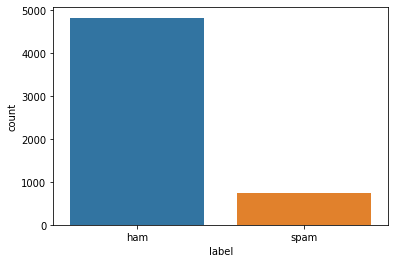

In [ ]:
# 4825 valid messages, 747 spam messages

print(df.label.value_counts()) 

sns.countplot(x=df['label'])
plt.show()

In [ ]:
# Create a dataframe for spam messages
spam = df[df["label"] == "spam"]
spam.head()

,label,text,encoding
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1


In [ ]:
# Create a dataframe for ham/valid messages
ham = df[df["label"] == "ham"]
ham.head()

,label,text,encoding
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
6,ham,Even my brother is not like to speak with me. ...,0


## Preprocessing

1. Use Scikit-learn's Tfidfvectorizer to convert the text into numbers 
2. Split the data into training (80%) and testing (20%) sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size = 0.2, random_state = 1)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Training (based on Gaussian Naive Bayes algorithm)

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)
y_true, y_pred = y_test, gnb.predict(X_test.toarray())
accuracy_score(y_true, y_pred) 

0.9085201793721973

In [ ]:
# summary of model accuracy for predictions
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         ham       0.99      0.91      0.95       976
        spam       0.58      0.92      0.72       139

    accuracy                           0.91      1115
   macro avg       0.79      0.91      0.83      1115
weighted avg       0.94      0.91      0.92      1115



In [ ]:
# confusion matrix (cm)
# interpretation: 885 messages predicted as ham were in fact ham
# 128 messages predicted as spam were in fact spam
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred, labels=['ham', 'spam']), 
    index=['ham', 'spam'], 
    columns=['ham', 'spam']
)

print(cm)

      ham  spam
ham   942    34
spam    4   135


### Optimizing Model's Accuracy through Grid Search

In [ ]:
# run the model through different hyperparameters
parameters = {"var_smoothing":[1e-1, 1e-5, 1e-9]} 
gs_gnb = GridSearchCV(GaussianNB(), parameters)
gs_gnb.fit(X_train.toarray(),y_train)

gs_gnb.best_params_ # 0.1 is the best parameter thus far

{'var_smoothing': 0.1}

In [ ]:
# 91.85% -> 96.59% accuracy!
y_true, y_pred = y_test, gs_gnb.predict(X_test.toarray())
accuracy_score(y_true, y_pred)

0.9659192825112107

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98       976
        spam       0.80      0.97      0.88       139

    accuracy                           0.97      1115
   macro avg       0.90      0.97      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [ ]:
# interpretation: 942 messages predicted as ham were in fact ham
# 135 messages predicted as spam were in fact spam
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred, labels=['ham', 'spam']), 
    index=['ham', 'spam'], 
    columns=['ham', 'spam']
)
print(cm)

      ham  spam
ham   942    34
spam    4   135


In [ ]:
# saving model and tf-idf vectorizer
joblib.dump(gs_gnb, "model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

## Testing

In [ ]:
text = vectorizer.transform(["Dinner @6?"]).toarray()
gs_gnb.predict(text)

array(['ham'], dtype='<U4')

In [ ]:
text = vectorizer.transform(["Good evening, please check your email for information about PRIDE night."]).toarray()
gs_gnb.predict(text)

array(['ham'], dtype='<U4')

In [ ]:
text = vectorizer.transform(["Are you ready for GWC Cyber Challenge?!"]).toarray()
gs_gnb.predict(text)

array(['ham'], dtype='<U4')

In [ ]:
text = vectorizer.transform(["GWC: LAST DAY to use your 20% OFF code!"]).toarray()
gs_gnb.predict(text)

array(['spam'], dtype='<U4')

In [ ]:
text = vectorizer.transform(["Did your family have plans to sell in the upcoming weeks? Reply END to unsubscribe."]).toarray()
gs_gnb.predict(text)

array(['spam'], dtype='<U4')

In [ ]:
text = vectorizer.transform(["FRM:Wbank234 SUBJ:PhoneUs-At-Urgent!"]).toarray()
gs_gnb.predict(text)

array(['spam'], dtype='<U4')